In [1934]:
# import necessary libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster  import KMeans
import matplotlib.pyplot as plt
import tqdm
import collections
import random
import seaborn as sns

In [1935]:
# set parameters

window_size = 5 # number of seconds in the timeframe to consider as a block for a cluster
max_iters = 100 # number of iterations before convergence
beta = 5 # smoothness penalty for switching between clusters ; higher value penalizes rapid changes between clusters
lambda_param = 0.01  # regularizer for sparsity in inverse covariance matrix ; higher value encourages sparser covariance matrix
k = 3 # number of clusters
threshold = 2e-5 # precision threshold for convergence ; lower value encourages greater precision ; may slow down convergence

Data Analysis and Train - Test split


In [1971]:
# fetch the dataset
df = pd.read_csv("/content/synthetic_data.csv", header=None)

In [1972]:
df.shape

(600, 10)

In [1973]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,2.5672,-1.1661,-0.7745,-0.9508,1.9138,1.1758,2.3942,0.4136,-2.0925,2.5859
1,1.4270,-0.1549,-2.5940,0.6291,-0.0863,-0.3167,0.2914,-0.0716,-1.0108,-0.7563
2,0.4794,-0.0894,-0.2066,-0.8571,0.4414,0.3096,0.3931,1.2203,0.4111,0.8279
3,-1.0594,0.3866,-0.7235,0.5233,-0.0424,0.6746,0.2188,-0.5660,-0.3942,-0.8338
4,-1.0064,1.5178,-0.1121,-0.0587,-2.3271,-1.8742,-2.3702,-1.0723,1.8430,-1.0734


In [1974]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,-0.031624,0.039877,0.022476,-0.014269,-0.070310,-0.018625,-0.031468,-0.010258,0.107967,-0.000219
std,0.751604,0.939508,0.854480,0.787426,1.009551,0.796442,0.899619,0.686724,0.928144,0.881045
min,-3.044600,-2.938900,-2.594000,-2.874100,-3.133600,-2.448300,-3.712800,-2.347600,-3.331600,-2.607300
25%,-0.533600,-0.585150,-0.555825,-0.540750,-0.664050,-0.511000,-0.592025,-0.491000,-0.410625,-0.624150
50%,-0.016350,0.019400,0.036650,-0.048300,-0.034850,-0.031700,0.021750,-0.020000,0.126850,-0.040350
75%,0.452825,0.620550,0.546125,0.551650,0.582650,0.521575,0.600650,0.427200,0.682850,0.581375
max,2.567200,3.370400,3.413300,2.552600,2.870400,2.448000,2.419200,2.768400,4.117900,2.876600


In [1940]:
# make sure there are no null values

df.isnull().sum().sum()

0

In [1941]:
# split data into train and test sets

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

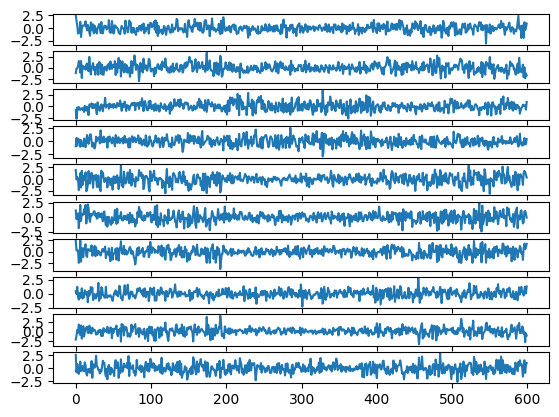

In [1975]:
# plotting all the data points

plt.figure()
for i in range(df.shape[1]):
  plt.subplot(df.shape[1], 1, i + 1)
  plt.plot(df[i])
  # plt.title(f"Sensor {i + 1}")
  # plt.xlabel("Time")
  # plt.ylabel("Value")
plt.show()

Windowing the time series data

In [1943]:
def window_data(data :np.ndarray, window_size: int = 10):

    n_samples, n_features = data.shape
    # each window is of the size window_size*n_features
    # there would be a total of n_samples - window_size + 1 windowed samples
    # since the last window_size - 1 elements cannot have window elements (zero indexing)
    windowed_data = np.zeros((n_samples - window_size + 1, window_size * n_features))
    for i in range(n_samples - window_size + 1):
        windowed_data[i] = data[i:i + window_size].flatten()
    return windowed_data

In [1944]:
# convert into np array to make use of array slicing
train_data = train_df.values
test_data = test_df.values

windowed_train_data = window_data(train_data, window_size)
windowed_test_data = window_data(test_data, window_size)

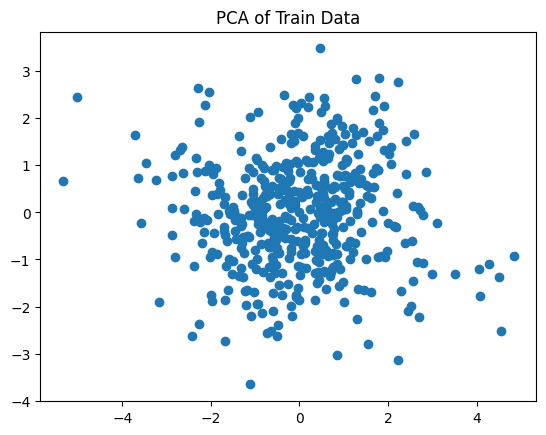

In [1945]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(train_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA of Train Data")
plt.show()

In [1946]:
print(np.std(train_data, axis=0))

[1.10539068 1.05040797 0.88339527 1.08231249 1.278982  ]


In [1947]:
print(f"Shape of windowed train data: {windowed_train_data.shape}")
print(f"Shape of windowed test data: {windowed_test_data.shape}")

Shape of windowed train data: (476, 25)
Shape of windowed test data: (116, 25)


Baseline: K-Means Clustering

In [1948]:
kmeans = KMeans(n_clusters=k, random_state=42).fit(windowed_train_data)
cluster_labels_train = kmeans.labels_
cluster_labels_test = kmeans.predict(windowed_test_data)

# TODO: compute a confusion matrix for this

In [1949]:
print(f"Train cluster distribution: {np.bincount(cluster_labels_train)}")
print(f"Test cluster distribution: {np.bincount(cluster_labels_test)}")

Train cluster distribution: [138 122 216]
Test cluster distribution: [36 30 50]


TICC

In [1950]:
# n_samples, n_features = train_data.shape

# # Initialization
# cluster_assignment = np.random.randint(k, size=len(windowed_train_data))
# cluster_covariance = [np.identity(window_size * n_features) for _ in range(k)]
# cluster_mean = [np.mean(windowed_train_data[np.where(cluster_assignment == i)], axis=0) for i in range(k)]

In [1951]:
class ADMM:
    def __init__(self, lamb, n_blocks, block_size, rho, S, rho_update_func=None):
        self.lamb = lamb
        self.n_blocks = n_blocks
        self.block_size = block_size
        self.rho = float(rho)
        self.S = S
        self.rho_update_func = rho_update_func
        self.status = None
        self.x = None
        self.z = None
        self.u = None

    @property
    def prob_size(self):
        return self.n_blocks * self.block_size

    @property
    def length(self):
        return int(self.prob_size * (self.prob_size + 1) / 2)

    @property
    def theta(self):
        return self.upper_to_full(self.x, eps=0)

    def initialize(self):
        self.x = np.zeros(self.length)
        self.z = np.zeros(self.length)
        self.u = np.zeros(self.length)
        self.status = 'Initialized'
        # print(f"Initialization: x shape: {self.x.shape}, z shape: {self.z.shape}, u shape: {self.u.shape}")

    @staticmethod
    def upper_to_full(a, eps=0):
        n = int((-1 + np.sqrt(1 + 8 * a.shape[0])) / 2)
        A = np.zeros([n, n])
        A[np.triu_indices(n)] = a
        temp = A.diagonal()
        A = np.asarray((A + A.T) - np.diag(temp))
        return A

    @staticmethod
    def ij_to_symmetric(i, j, size):
        return int((size * (size + 1)) / 2 - (size - i) * (size - i + 1) / 2 + j - i)


    # def update_theta(self):
    #     """
    #     Update Theta using the equation:
    #     Θ^(k+1) = (1 / (2 * rho)) * Q * (D + sqrt(D^2 + 4 * rho * I)) * Q^T
    #     """
    #     A = self.upper_to_full(self.z - self.u)
    #     eta = self.rho

    #     # Eigen decomposition
    #     d, Q = np.linalg.eigh(eta * A - self.S)
    #     D = np.diag(d)
    #     sqrt_term = np.sqrt(D**2 + 4 * eta * np.eye(D.shape[0]))

    #     # Theta update equation
    #     theta_update = (1 / (2 * eta)) * Q @ (D + sqrt_term) @ Q.T
    #     self.x = theta_update[np.triu_indices(theta_update.shape[0])]

    def update_theta(self):
        A = self.upper_to_full(self.z - self.u)
        eta = self.rho

        # Eigen decomposition with a small regularization term
        d, Q = np.linalg.eigh(eta * A - self.S)
        d = np.clip(d, a_min=-1e2, a_max=1e2)  # Clip extreme eigenvalues

        # Add a small positive regularization to avoid overflow
        regularization = 1e-3
        sqrt_term = np.sqrt(np.maximum(d**2 + 4 * eta * regularization, 0))

        # Theta update equation
        theta_update = (1 / (2 * eta)) * (Q @ np.diag(d + sqrt_term) @ Q.T)

        # Extract upper triangular elements
        self.x = theta_update[np.triu_indices(theta_update.shape[0])]

    def update_z(self):
        """
        Update Z using the equation:
        Z^(k+1)_B_ij =
            (rho * sum_l S_l - Q) / rho * R if > 0,
            (rho * sum_l S_l + Q) / rho * R if < 0,
            0 otherwise.
        """
        a = self.x + self.u
        prob_size = self.n_blocks * self.block_size
        z_update = np.zeros(self.length)

        for i in range(self.n_blocks):
            for j in range(self.block_size):
                indices = [self.ij_to_symmetric(i, j, prob_size)]
                sum_S = np.sum(self.S[i, j])

                for idx in indices:
                    val = self.rho * sum_S - a[idx]
                    if val / self.rho > 0:
                        z_update[idx] = val / self.rho
                    elif val / self.rho < 0:
                        z_update[idx] = val / self.rho
                    else:
                        z_update[idx] = 0

        self.z = z_update

    def update_u(self):
        """
        Update U using the equation:
        U^(k+1) = U^k + (Theta^(k+1) - Z^(k+1))
        """
        self.u += self.x - self.z

    def run(self, max_iters, eps_abs, eps_rel, verbose=False):
        self.initialize()

        for i in range(max_iters):
            z_old = np.copy(self.z)
            self.update_theta()
            self.update_z()
            self.update_u()

            # Convergence check
            if np.linalg.norm(self.x - self.z) < eps_abs and np.linalg.norm(self.rho * (self.z - z_old)) < eps_rel:
                self.status = 'Optimal'
                break

            if verbose:
                print(f'Iteration {i}: Convergence check passed')

        return self

In [1952]:
def m_step(windowed_data, cluster_assignments, num_clusters, lambda_param, window_size, rho=1.0, max_iters=1000, eps_abs=1e-6, eps_rel=1e-6, verbose=False):
    num_features = windowed_data.shape[1]
    block_size = num_features // window_size

    inverse_covariances = []
    means = []

    for cluster in range(num_clusters):
        cluster_data = []
        for i in range(len(windowed_data)):
            if cluster_assignments[i] == cluster:
                cluster_data.append(windowed_data[i])

        cluster_data = np.array(cluster_data)
        print(f"Cluster {cluster} has {len(cluster_data)} points.")

        if len(cluster_data) < window_size:
            print(f"Cluster {cluster} has too few points ({len(cluster_data)}). Using fallback.")
            inverse_covariances.append(np.eye(num_features))
            means.append(np.zeros(num_features))
            continue

        # Compute empirical covariance with regularization
        empirical_cov = np.cov(cluster_data, rowvar=False)
        empirical_cov += np.eye(num_features) * 10.0

        # Ensure the covariance matrix is symmetric
        empirical_cov = (empirical_cov + empirical_cov.T) / 2

        # print(f"Empirical Covariance for Cluster {cluster}:\n{empirical_cov}")

        # Check condition number of the covariance matrix
        condition_number = np.linalg.cond(empirical_cov)
        if verbose:
            print(f"\nCluster {cluster}: Condition number of empirical covariance: {condition_number:.2e}")

        # Try eigen decomposition with SVD fallback
        try:
            # Attempt eigen decomposition
            w, v = np.linalg.eigh(empirical_cov)
            w = np.clip(w, a_min=1e-6, a_max=None)
            empirical_cov = (v @ np.diag(w) @ v.T).real
        except np.linalg.LinAlgError:
            print(f"Eigenvalue decomposition failed for cluster {cluster}. Trying SVD fallback.")
            try:
                # Use SVD as a fallback
                U, s, Vt = np.linalg.svd(empirical_cov)
                s = np.clip(s, a_min=1e-6, a_max=None)
                empirical_cov = (U @ np.diag(s) @ Vt).real
            except np.linalg.LinAlgError:
                print(f"SVD also failed for cluster {cluster}. Using identity matrix as fallback.")
                empirical_cov = np.eye(num_features)

        # Initialize and run ADMM solver
        try:
            admm_solver = ADMM(
                lamb=np.full((num_features, num_features), lambda_param),
                n_blocks=window_size,
                block_size=block_size,
                rho=rho,
                S=empirical_cov
            )

            admm_solver.run(max_iters=max_iters, eps_abs=eps_abs, eps_rel=eps_rel, verbose=verbose)

            # print(f"Cluster {cluster} Inverse Covariance Matrix:\n", admm_solver.theta)

            # Store the inverse covariance and mean for the cluster
            inverse_covariances.append(admm_solver.theta)
            means.append(np.mean(cluster_data, axis=0))

            if verbose:
                print(f"Cluster {cluster}: ADMM optimization completed.")
        except Exception as e:
            print(f"ADMM solver failed for cluster {cluster}: {e}. Using identity matrix as fallback.")
            inverse_covariances.append(np.eye(num_features))
            means.append(np.zeros(num_features))

    return inverse_covariances, means


In [1953]:
def assign_cluster(lle, beta_param):
    # e-step

    t, k = lle.shape
    # Initialize costs and paths
    prev_cost = [0] * k
    prev_path = [[j] for j in range(k)]

    for i in range(1, t):
        curr_cost = [0] * k
        curr_path = [[] for _ in range(k)]

        for j in range(k):
            # Calculate cost for staying in the same cluster
            # stay_cost = prev_cost[j] - lle[i][j]
            stay_cost = prev_cost[j] + lle[i][j]

            # Calculate cost for switching to a different cluster
            # switch_cost = [prev_cost[m] + beta_param - lle[i][j] for m in range(k)]
            switch_cost = [prev_cost[m] + (beta_param if m != j else 0) + lle[i][j] for m in range(k)]
            min_switch_cost = min(switch_cost)

            # Choose the better option: stay or switch
            if stay_cost <= min_switch_cost:
                curr_cost[j] = stay_cost
                curr_path[j] = prev_path[j] + [j]
            else:
                min_switch_index = np.argmin(switch_cost)
                curr_cost[j] = min_switch_cost
                curr_path[j] = prev_path[min_switch_index] + [j]

        # Update for next iteration
        prev_cost = curr_cost
        prev_path = curr_path

    # print(f'Cluster assignment {prev_path[np.argmin(prev_cost)]}')
    # Return the path with the minimum cost
    return prev_path[np.argmin(prev_cost)]

In [1954]:
import numpy as np
import tqdm

# Initialize variables
cluster_assignment = KMeans(n_clusters=k, random_state=0).fit_predict(windowed_train_data)  # Kmeans initial cluster assignments
cluster_covariance = [np.eye(windowed_train_data.shape[1]) for _ in range(k)]  # Initialize covariance matrices
cluster_mean = [np.zeros(windowed_train_data.shape[1]) for _ in range(k)]  # Initialize means

print("Initial Cluster Assignments:", np.unique(cluster_assignment, return_counts=True))


# TICC iterations
for iteration in tqdm.tqdm(range(10)):
    # M-step: Optimize covariance and mean for each cluster
    cov_inv, cluster_mean = m_step(
    windowed_data=windowed_train_data,
    cluster_assignments=cluster_assignment,
    num_clusters=k,
    lambda_param=lambda_param,
    window_size=window_size,
    rho=5.0,
    max_iters=1000,
    eps_abs=1e-8,
    eps_rel=1e-8,
    verbose=False)

    # E-step: Calculate log-likelihood for each point-cluster pair
    lle = np.zeros((len(windowed_train_data), k))
    for j in range(k):
        cluster_covariance = np.linalg.inv(cov_inv[j])  # Inverse covariance
        diff = windowed_train_data - cluster_mean[j]  # Broadcasted difference
        sign, logdet = np.linalg.slogdet(cluster_covariance)
        if sign <= 0:
            raise ValueError(f"Covariance matrix for cluster {j} is non-positive definite.")
        lle[:, j] = (
            -0.5 * np.sum(diff @ cov_inv[j] * diff, axis=1)
            + 0.5 * logdet
            - 0.5 * windowed_train_data.shape[1] * np.log(2 * np.pi)
        )

    # Assign clusters with temporal consistency
    new_cluster_assignment = assign_cluster(lle, beta)


    # Log-likelihood values
    # print(f"Log-Likelihood Matrix (lle):\n{lle[:5]}")

    # Assign clusters with temporal consistency
    new_cluster_assignment = assign_cluster(lle, beta)

    # Debugging: Check new assignments
    print(f"Iteration {iteration + 1}: New Cluster Assignments = {np.unique(new_cluster_assignment, return_counts=True)}")

    # Check for convergence
    changes = np.sum(cluster_assignment != new_cluster_assignment)
    print(f"Iteration {iteration + 1}: Changes = {changes}")
    if changes / len(cluster_assignment) < 0.01:  # Less than 1% change
        print(f"Converged after {iteration + 1} iterations.")
        # break

    # Update cluster assignments
    cluster_assignment = new_cluster_assignment

print("Final Cluster Assignment:", np.unique(cluster_assignment))


Initial Cluster Assignments: (array([0, 1, 2], dtype=int32), array([194, 158, 124]))


  0%|          | 0/10 [00:00<?, ?it/s]

Cluster 0 has 194 points.
Cluster 1 has 158 points.
Cluster 2 has 124 points.


 10%|█         | 1/10 [00:01<00:16,  1.85s/it]

Iteration 1: New Cluster Assignments = (array([0, 1, 2]), array([  2,   5, 469]))
Iteration 1: Changes = 356
Cluster 0 has 2 points.
Cluster 0 has too few points (2). Using fallback.
Cluster 1 has 5 points.
Cluster 2 has 469 points.


 20%|██        | 2/10 [00:02<00:11,  1.43s/it]

Iteration 2: New Cluster Assignments = (array([0, 1, 2]), array([ 38, 434,   4]))
Iteration 2: Changes = 1
Converged after 2 iterations.
Cluster 0 has 38 points.
Cluster 1 has 434 points.


 30%|███       | 3/10 [00:04<00:09,  1.31s/it]

Cluster 2 has 4 points.
Cluster 2 has too few points (4). Using fallback.
Iteration 3: New Cluster Assignments = (array([0, 1, 2]), array([  4,  21, 451]))
Iteration 3: Changes = 1
Converged after 3 iterations.
Cluster 0 has 4 points.
Cluster 0 has too few points (4). Using fallback.
Cluster 1 has 21 points.
Cluster 2 has 451 points.


 40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Iteration 4: New Cluster Assignments = (array([0, 1]), array([  8, 468]))
Iteration 4: Changes = 1
Converged after 4 iterations.
Cluster 0 has 8 points.
Cluster 1 has 468 points.


 50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

Cluster 2 has 0 points.
Cluster 2 has too few points (0). Using fallback.
Iteration 5: New Cluster Assignments = (array([0, 1, 2]), array([247,   8, 221]))
Iteration 5: Changes = 1
Converged after 5 iterations.
Cluster 0 has 247 points.
Cluster 1 has 8 points.
Cluster 2 has 221 points.


 60%|██████    | 6/10 [00:11<00:09,  2.29s/it]

Iteration 6: New Cluster Assignments = (array([0, 1]), array([ 51, 425]))
Iteration 6: Changes = 1
Converged after 6 iterations.
Cluster 0 has 51 points.
Cluster 1 has 425 points.


 70%|███████   | 7/10 [00:13<00:06,  2.28s/it]

Cluster 2 has 0 points.
Cluster 2 has too few points (0). Using fallback.
Iteration 7: New Cluster Assignments = (array([0, 1, 2]), array([335,   2, 139]))
Iteration 7: Changes = 1
Converged after 7 iterations.
Cluster 0 has 335 points.
Cluster 1 has 2 points.
Cluster 1 has too few points (2). Using fallback.
Cluster 2 has 139 points.


 80%|████████  | 8/10 [00:14<00:03,  1.93s/it]

Iteration 8: New Cluster Assignments = (array([0, 1]), array([148, 328]))
Iteration 8: Changes = 1
Converged after 8 iterations.
Cluster 0 has 148 points.
Cluster 1 has 328 points.


 90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]

Cluster 2 has 0 points.
Cluster 2 has too few points (0). Using fallback.
Iteration 9: New Cluster Assignments = (array([0, 1, 2]), array([349,   1, 126]))
Iteration 9: Changes = 1
Converged after 9 iterations.
Cluster 0 has 349 points.
Cluster 1 has 1 points.
Cluster 1 has too few points (1). Using fallback.
Cluster 2 has 126 points.


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

Iteration 10: New Cluster Assignments = (array([0, 1, 2]), array([ 43, 432,   1]))
Iteration 10: Changes = 1
Converged after 10 iterations.
Final Cluster Assignment: [0 1 2]


In [1955]:
estimated_inverse_covariances = cov_inv
estimated_covariances = [np.linalg.inv(cov) for cov in estimated_inverse_covariances]

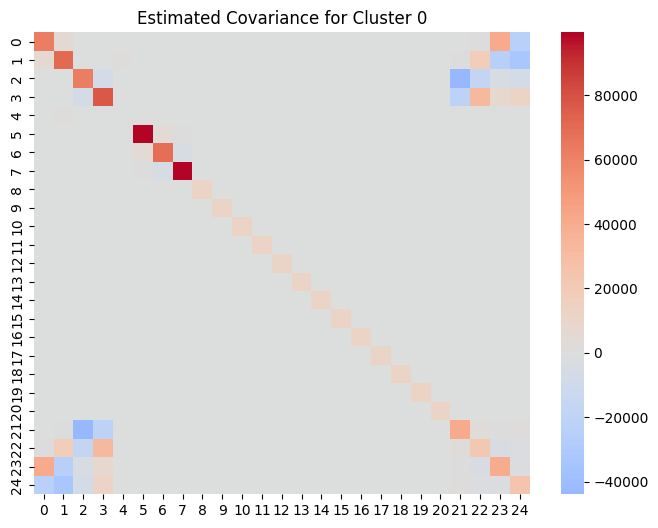

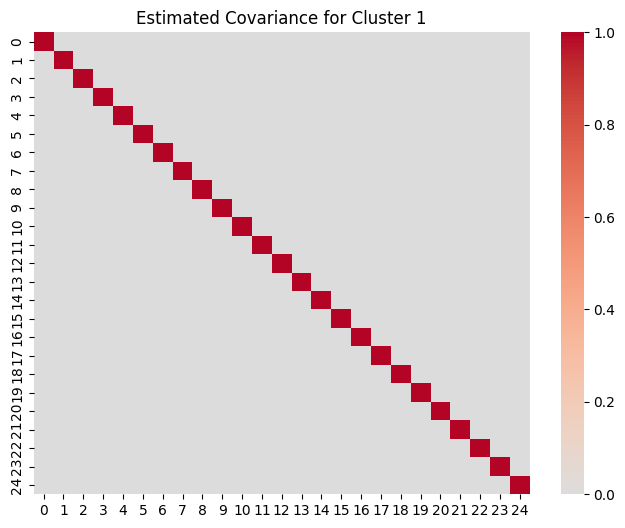

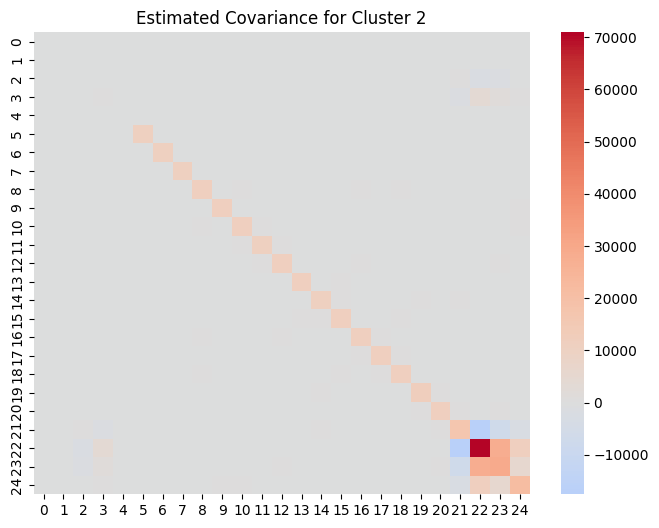

In [1956]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    cluster = np.linalg.inv(cov_inv[i])
    sns.heatmap(cluster, cmap='coolwarm', center=0)
    plt.title(f"Estimated Covariance for Cluster {i}")
    plt.show()

In [1957]:
cluster1_gt = pd.read_csv("/content/covariance_cluster_0.csv", header=None)
cluster2_gt = pd.read_csv("/content/covariance_cluster_1.csv", header=None)
cluster3_gt = pd.read_csv("/content/covariance_cluster_2.csv", header=None)


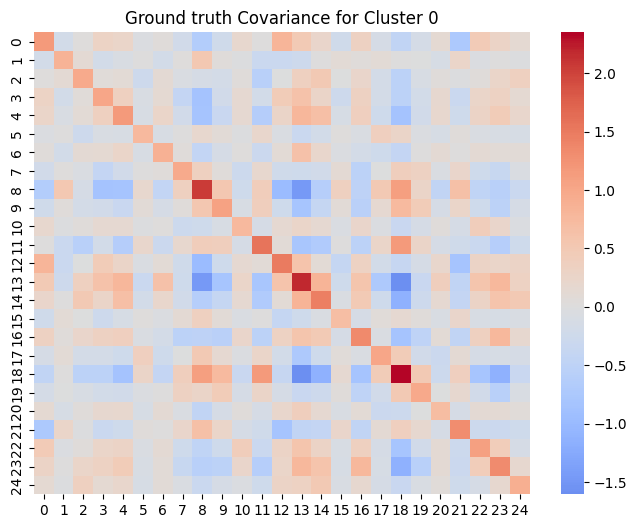

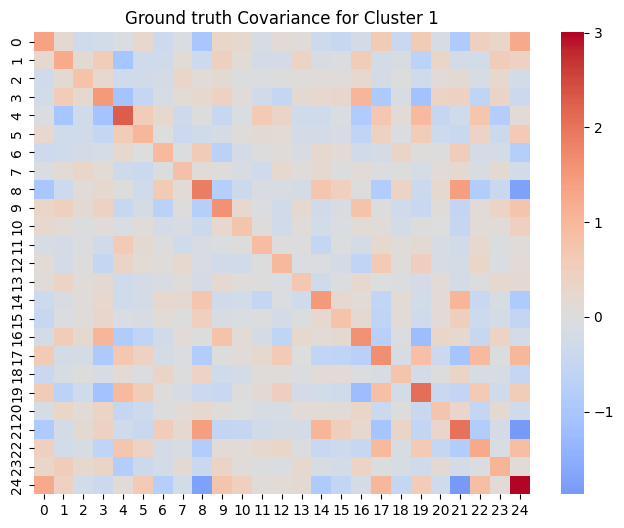

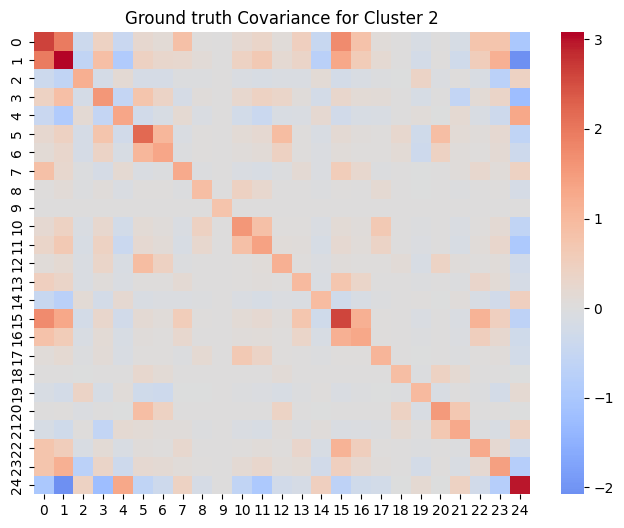

In [1958]:
for i in range(3):
    plt.figure(figsize=(8, 6))
    cluster = pd.read_csv(f"/content/covariance_cluster_{i}.csv", header=None).to_numpy()
    sns.heatmap(cluster, cmap='coolwarm', center=0)
    plt.title(f"Ground truth Covariance for Cluster {i}")
    plt.show()

Evaluation

In [1959]:
# Inverse covariance matrices ground truth
cov_matrices_gt = [cluster1_gt, cluster2_gt, cluster3_gt]
inv_cov_matrices_gt = [np.linalg.inv(cov) for cov in cov_matrices_gt]
# cluster_means = [np.zeros(windowed_test_data.shape[1]) for _ in range(k)]

In [1960]:
def generate_cluster_assignments(cov_matrices, windowed_data, cluster_means, k, beta):
    # E-step: Calculate log-likelihood for each point-cluster pair
    lle = np.zeros((len(windowed_data), k))

    inv_cov_matrices = [np.linalg.inv(cov) for cov in cov_matrices]

    for j in range(k):
      diff = windowed_data - cluster_means[j]
      sign, logdet = np.linalg.slogdet(cov_matrices[j])
      if sign <= 0:
          raise ValueError(f"Covariance matrix for cluster {j} is non-positive definite.")
      lle[:, j] = (
          -0.5 * np.sum(diff @ inv_cov_matrices[j] * diff, axis=1)
          + 0.5 * logdet
          - 0.5 * windowed_data.shape[1] * np.log(2 * np.pi)
      )

    return assign_cluster(lle, beta)

In [1961]:
gt_cluster_assignment = generate_cluster_assignments(cov_matrices_gt, windowed_test_data, cluster_mean, k, beta)
estimated_cluster_assignment = generate_cluster_assignments(estimated_covariances, windowed_test_data, cluster_mean, k, beta)

In [1962]:
from sklearn.metrics import f1_score

In [1963]:
print(f'Macro F1 Score: {f1_score(gt_cluster_assignment, estimated_cluster_assignment, average="macro")}')


Macro F1 Score: 0.2374080362195812


In [1964]:
def plot_clusters(data, cluster_assignments, title="Cluster Plot"):

    # Convert data to a NumPy array if it's not already
    data = np.array(data)
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='viridis', s=30, alpha=0.7, edgecolors='k')
    plt.title(title)
    plt.grid(True)
    plt.show()

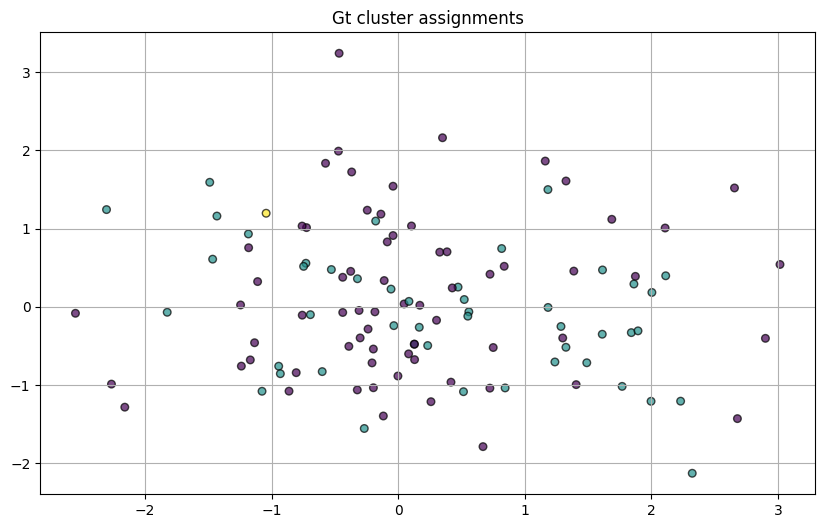

In [1965]:
plot_clusters(windowed_test_data, gt_cluster_assignment, title="Gt cluster assignments")

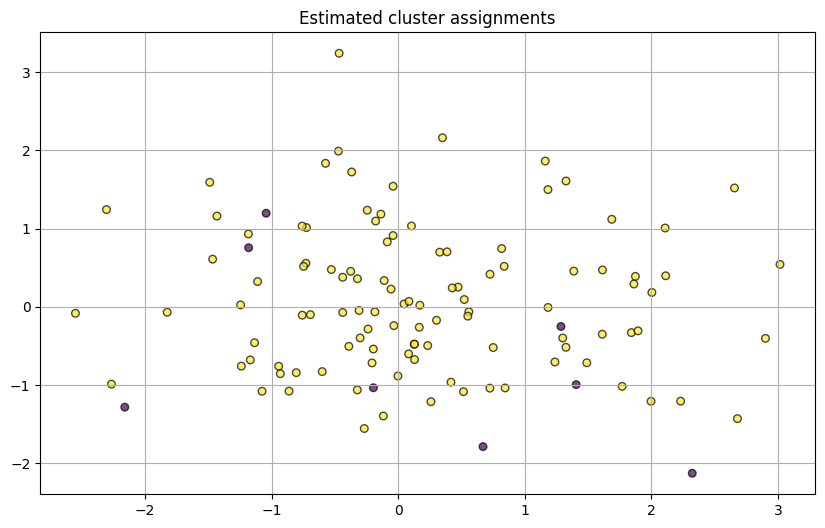

In [1966]:
plot_clusters(windowed_test_data, estimated_cluster_assignment, title="Estimated cluster assignments")

In [1967]:
kmeans_cluster_assignment = KMeans(n_clusters=k, random_state=42).fit(windowed_test_data)

In [1968]:
kmeans_cluster_assignment = kmeans_cluster_assignment.labels_

In [1969]:
print(f'Macro F1 Score: {f1_score(gt_cluster_assignment, kmeans_cluster_assignment, average="macro")}')

Macro F1 Score: 0.280384318675924


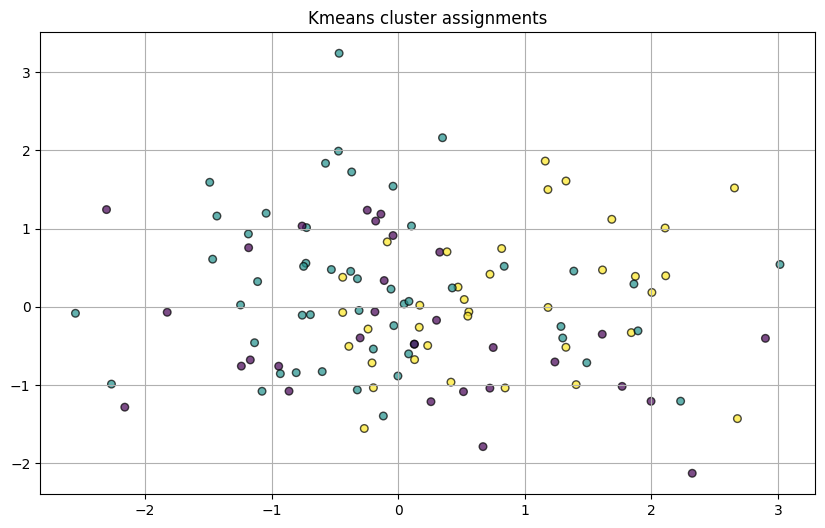

In [1970]:
plot_clusters(windowed_test_data, kmeans_cluster_assignment, title="Kmeans cluster assignments")